# TSMixer: Forecast

- load trained model
- compute ensemble
- export in submission format

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [2]:
from darts.models import TSMixerModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


### Configuration

In [3]:
NUM_SAMPLES = 1000
HORIZON = 4

# Load data

In [4]:
current_date = pd.Timestamp.now().date()
forecast_date = get_preceding_thursday(current_date)
forecast_date = str(forecast_date.date())
forecast_date

'2024-10-24'

In [5]:
ts_are = load_target_series('are', forecast_date)
ts_sari = load_target_series('sari', forecast_date)

target_series, covariates = retain_period_common_to_all([ts_sari, ts_are])

<Axes: xlabel='date'>

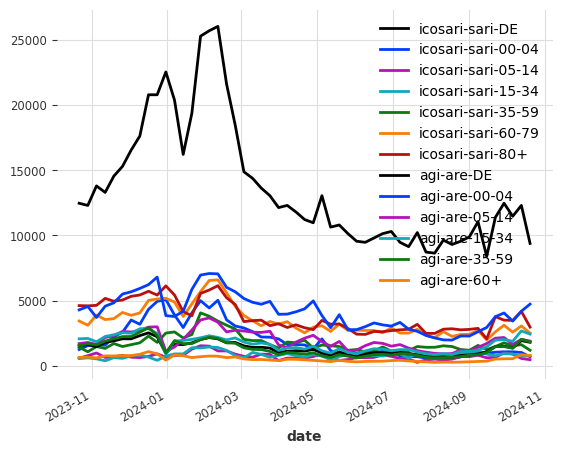

In [6]:
target_series.plot()
covariates.plot()

In [7]:
RANDOM_SEEDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [8]:
path = f'../models/realtime/{forecast_date}/'

In [9]:
dfs = []
for seed in RANDOM_SEEDS:
    model_path = path + f'{forecast_date}-tsmixer-{seed}.pt'
    print(model_path)
    model = TSMixerModel.load(model_path)
    df = compute_forecast(model, target_series, None, forecast_date, HORIZON, NUM_SAMPLES, vincentization=True, probabilistic_nowcast=True, local=True)
    dfs.append(df)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 0:00:12 • 0:00:00 0.28it/s

In [10]:
df = pd.concat(dfs)
df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()

In [11]:
df = df.sort_values(['location', 'age_group', 'horizon', 'quantile'])

In [12]:
df.to_csv(f'../data/submissions/KIT-TSMixer/{forecast_date}-icosari-sari-KIT-TSMixer.csv', index=False)

# Plot forecasts

In [13]:
df_plot = prepare_plot_data(df, target_series)

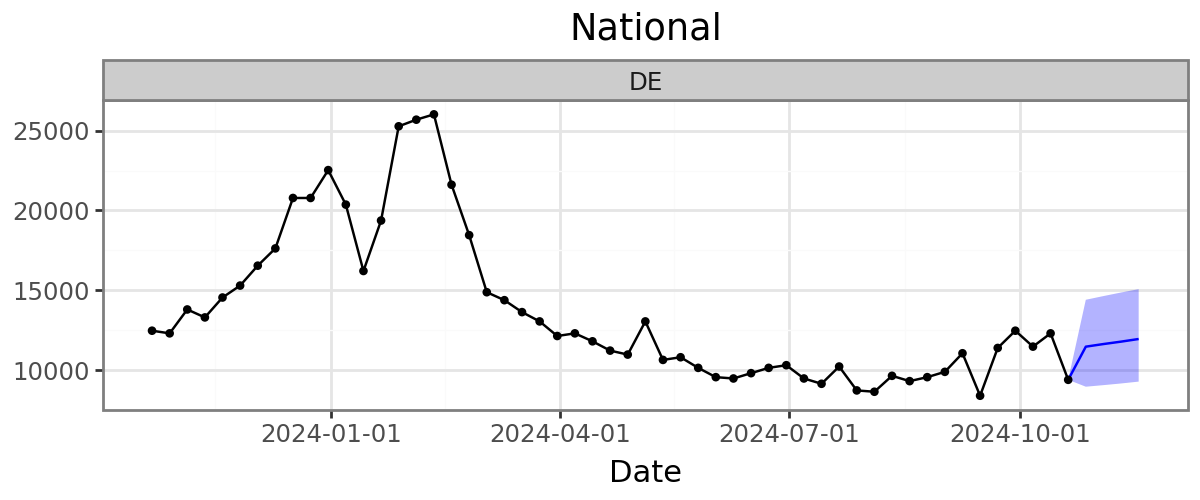

In [14]:
plot_forecasts(df_plot, 'national', start=0)

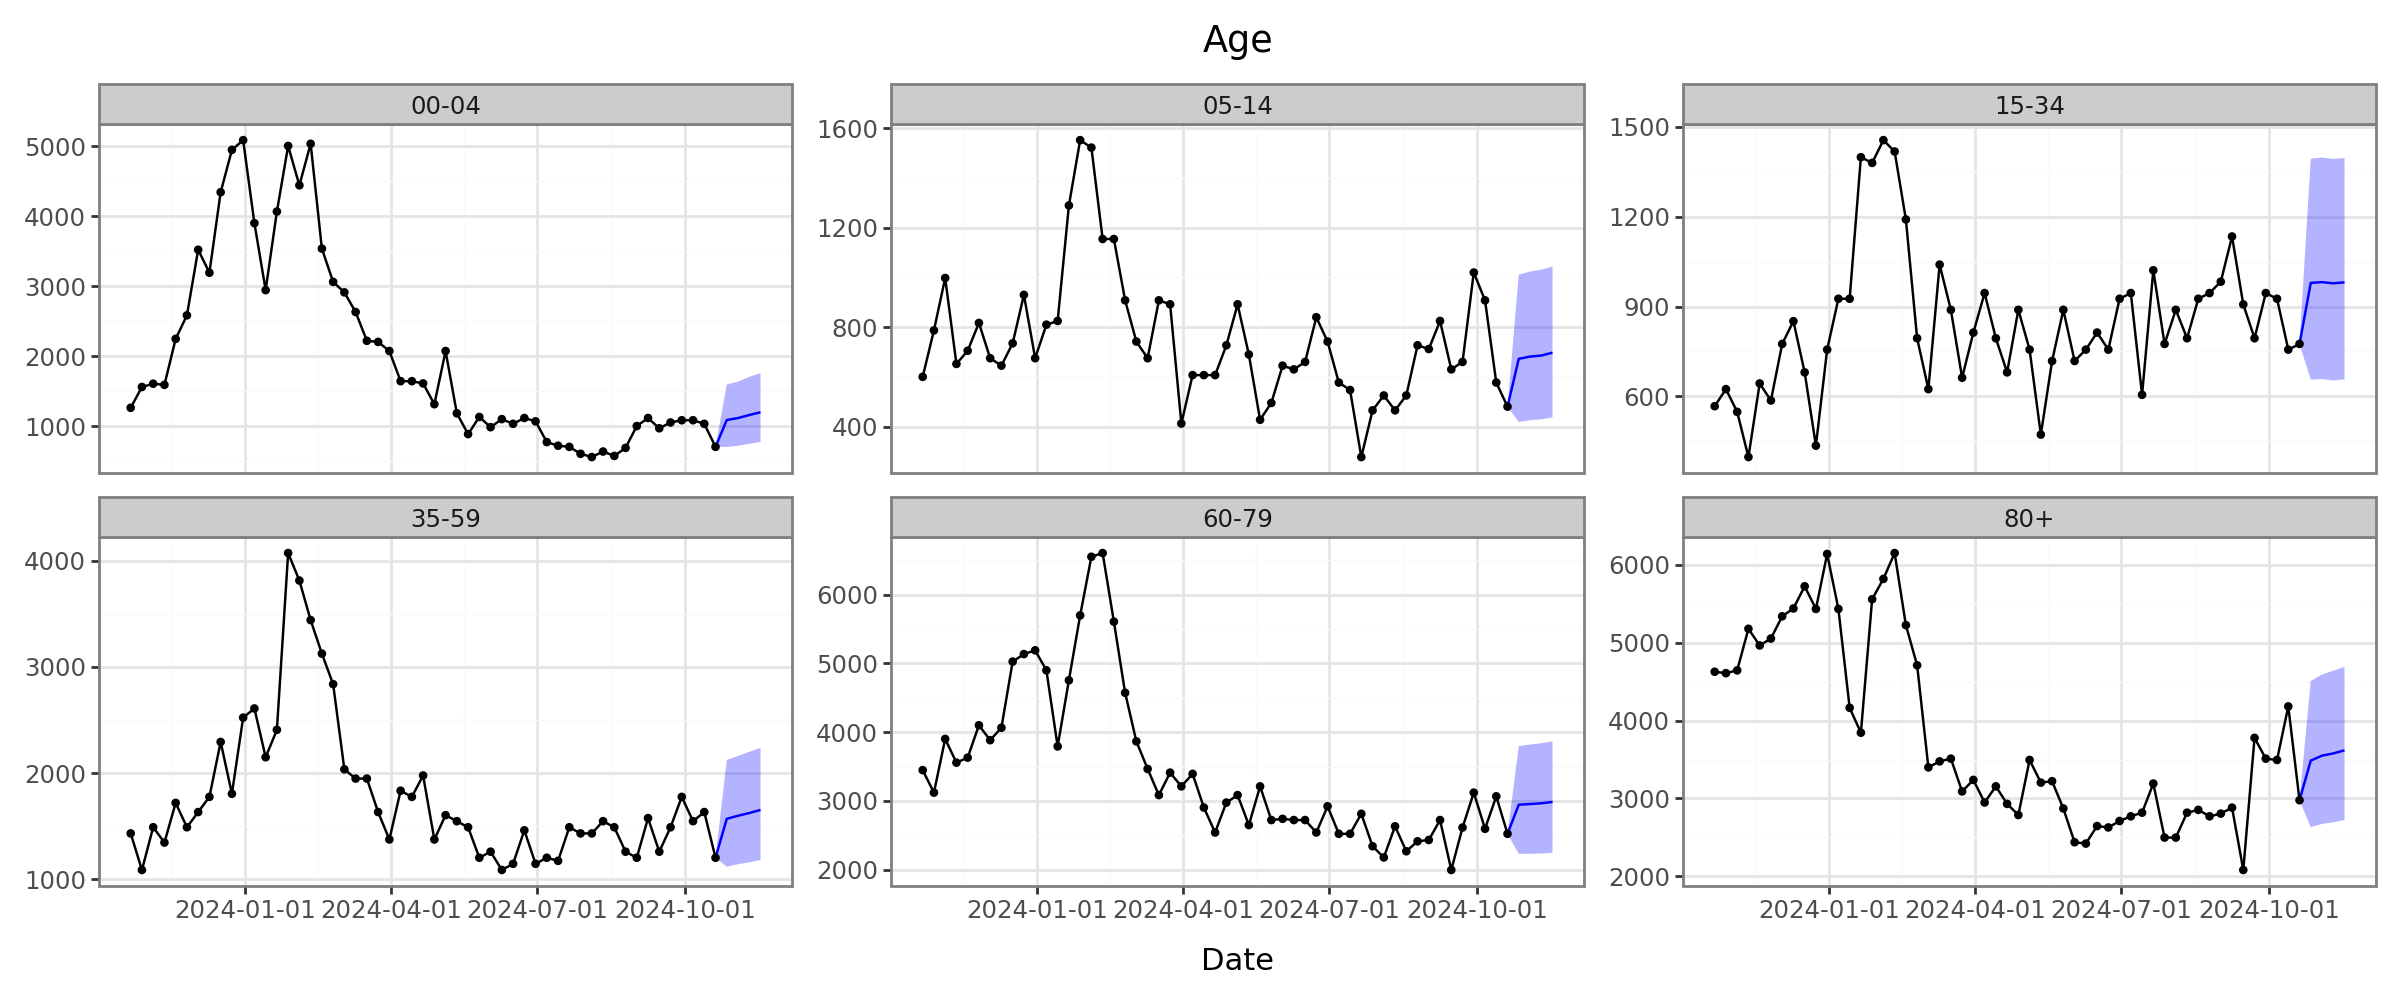

In [15]:
plot_forecasts(df_plot, 'age', start=0)